### Workflow with Orchestration and integration with OCI APM

Implements the following design pattern:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker
* in this version the json schema is derived (using: model_json_schema())
* integrate with OCI APM to add observability

In [1]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

from oci_models import create_model_for_routing, create_model_for_answer_directly

# added to integrate with APM
from py_zipkin import Encoding
from py_zipkin.zipkin import zipkin_span
from transport import http_transport

In [2]:
# used for APM tracing
SERVICE_NAME = "Orchestration01"

In [3]:
# models used in the rest of the code
llm = create_model_for_routing()
llm_ad = create_model_for_answer_directly()


# Schema for structured output to use in planning
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    workflow state
    """

    section: Section
    completed_sections: Annotated[list, operator.add]


# Augment the LLM with schema for structured output
json_schema = Sections.model_json_schema()

planner = llm.with_structured_output(json_schema)

In [4]:
# Nodes
@zipkin_span(service_name=SERVICE_NAME, span_name="orchestrator")
def orchestrator(state: State):
    """Orchestrator: generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            HumanMessage(
                content=f"""Generate a plan for the report.\n
            Follow strictly the following JSON SCHEMA: {str(json_schema)}
            Here is the report topic: {state['topic']}
            """
            ),
        ]
    )

    # print(type(report_sections))
    # print(report_sections)

    return {"sections": report_sections["sections"]}


# in this one the span name is set inside
def llm_call(state: WorkerState):
    """a Worker, writes a section of the report"""

    # here we embed the section name in the span name.
    SPAN_NAME = f"llm_call, {state['section']['name']}"

    with zipkin_span(
        service_name=SERVICE_NAME,
        span_name=SPAN_NAME,
    ):
        # Generate section
        # we're using another model
        section = llm_ad.invoke(
            [
                SystemMessage(
                    content="""Write a report section following the provided name and description. 
                    Include no preamble for each section. Use markdown formatting."""
                ),
                HumanMessage(
                    content=f"Here is the section name: {state['section']['name']} and description: {state['section']['description']}"
                ),
            ]
        )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


@zipkin_span(service_name=SERVICE_NAME, span_name="synthesizer")
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
@zipkin_span(service_name=SERVICE_NAME, span_name="assign_workers")
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        print(
            f"{i+1} Calling llm for section {s['name']}\nDescription: {s['description']}"
        )

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [5]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

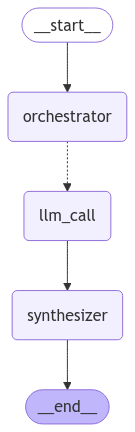

In [6]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
#
# Helper functions
#
def invoke_agent(user_request: str):
    """
    start the trace
    """
    with zipkin_span(
        service_name="Orchestration01",
        span_name="trace01",
        transport_handler=http_transport,
        encoding=Encoding.V2_JSON,
        sample_rate=100,  # this is optional and can be used to set custom sample rates
    ):
        # here we invoke the agent
        state = orchestrator_worker.invoke({"topic": user_request})

    return state


def print_final_report(state):
    display(Markdown(state["final_report"]))

In [8]:
# Invoke
state = invoke_agent("Create a report on AI Agents")

1 Calling llm for section Introduction
Description: An overview of the report and its purpose.
2 Calling llm for section What are AI Agents?
Description: A definition of AI agents and their role in artificial intelligence.
3 Calling llm for section Types of AI Agents
Description: A discussion of different types of AI agents, including their capabilities and applications.
4 Calling llm for section Applications of AI Agents
Description: A deep dive into various industries and use cases where AI agents are making an impact.
5 Calling llm for section Challenges and Ethical Considerations
Description: An exploration of the challenges and ethical dilemmas associated with AI agents, including privacy, bias, and accountability.
6 Calling llm for section Conclusion
Description: A summary of the key insights and takeaways from the report.


In [9]:
print_final_report(state)

### Introduction and Description
The purpose of this report is to provide a comprehensive overview of the current state of affairs in the industry, highlighting key trends, challenges, and opportunities. It aims to inform stakeholders, including investors, policymakers, and industry professionals, about the latest developments and their potential impact on the market. The report is based on extensive research, analysis, and data collection, ensuring that the information presented is accurate, reliable, and up-to-date. By examining the industry's performance, growth prospects, and potential risks, this report seeks to equip readers with the knowledge and insights necessary to make informed decisions and stay ahead of the curve.

---

### What are AI Agents?
AI agents are autonomous entities that use artificial intelligence to perceive their environment, make decisions, and take actions to achieve specific goals. They are programmed to perform tasks independently, using algorithms and data to guide their behavior. AI agents can be simple or complex, ranging from chatbots that respond to basic queries to sophisticated systems that can learn, adapt, and interact with humans and other agents. Their role in artificial intelligence is to automate tasks, provide personalized experiences, and enhance decision-making capabilities. AI agents can be categorized into different types, including:
* **Reactive agents**: Respond to the current state of the environment without considering future consequences.
* **Proactive agents**: Anticipate and plan for future events to achieve their goals.
* **Autonomous agents**: Operate independently, making decisions without human intervention.
* **Social agents**: Interact with humans and other agents to achieve common goals or provide services.

---

### Types of AI Agents
There are several types of AI agents, each with its own capabilities and applications. 
#### Simple Reflex Agents
* React to the current state of the environment
* Do not have the ability to look ahead or plan
* Examples include thermostats and basic chatbots
#### Model-Based Reflex Agents
* Maintain an internal model of the environment
* Can look ahead and plan, but only to a limited extent
* Examples include autonomous vehicles and robots
#### Goal-Based Agents
* Have specific goals and can plan to achieve them
* Can be used in applications such as scheduling and planning
* Examples include virtual assistants and personal organizers
#### Utility-Based Agents
* Make decisions based on a utility function that determines the best action
* Can be used in applications such as game playing and decision making
* Examples include chess playing computers and recommender systems
#### Learning Agents
* Can learn from experience and improve over time
* Can be used in applications such as natural language processing and computer vision
* Examples include speech recognition systems and image classification algorithms

---

### Applications of AI Agents
AI agents are being utilized in a wide range of industries, transforming the way businesses operate and creating new opportunities for growth. Some of the key applications of AI agents include:
#### Healthcare
* **Personalized medicine**: AI agents can analyze medical records, genetic data, and lifestyle information to provide personalized treatment recommendations.
* **Disease diagnosis**: AI-powered agents can help doctors diagnose diseases more accurately and quickly by analyzing medical images, lab results, and patient symptoms.
* **Patient engagement**: AI agents can interact with patients, provide them with personalized health advice, and remind them to take their medication.

#### Finance
* **Portfolio management**: AI agents can analyze market trends, predict stock prices, and optimize investment portfolios to maximize returns.
* **Risk management**: AI-powered agents can identify potential risks, detect anomalies, and alert financial institutions to potential threats.
* **Customer service**: AI agents can provide 24/7 customer support, helping customers with transactions, answering queries, and resolving issues.

#### Transportation
* **Autonomous vehicles**: AI agents can control self-driving cars, trucks, and drones, improving safety, reducing traffic congestion, and increasing efficiency.
* **Route optimization**: AI-powered agents can analyze traffic patterns, optimize routes, and reduce fuel consumption.
* **Predictive maintenance**: AI agents can predict when vehicles are likely to require maintenance, reducing downtime and improving overall performance.

#### Education
* **Personalized learning**: AI agents can create customized learning plans, adapting to individual students' needs, abilities, and learning styles.
* **Intelligent tutoring**: AI-powered agents can provide one-on-one support, offering real-time feedback, and helping students overcome knowledge gaps.
* **Automated grading**: AI agents can grade assignments, quizzes, and exams, freeing up instructors to focus on teaching and mentoring.

#### Customer Service
* **Chatbots**: AI agents can engage with customers, answer queries, and provide support through messaging platforms, websites, and mobile apps.
* **Sentiment analysis**: AI-powered agents can analyze customer feedback, detect sentiment, and alert companies to potential issues.
* **Recommendation systems**: AI agents can suggest products, services, and content based on customers' preferences, behavior, and purchase history.

---

### Challenges and Ethical Considerations
#### Introduction to Challenges
AI agents pose significant challenges and ethical considerations, including concerns related to **privacy**, **bias**, and **accountability**. As AI systems become increasingly integrated into daily life, it is essential to address these issues to ensure that the benefits of AI are realized while minimizing its risks.

#### Privacy Concerns
Privacy is a major concern when it comes to AI agents, as they often rely on vast amounts of personal data to function effectively. This raises questions about **data protection**, **consent**, and **surveillance**. For instance, AI-powered virtual assistants like Alexa and Google Home collect and store vast amounts of audio data, which can be used to infer sensitive information about individuals.

#### Bias and Discrimination
AI systems can perpetuate and amplify existing biases and discriminatory practices, particularly if they are trained on biased data. This can result in **unfair outcomes** and **discrimination** against certain groups of people. For example, AI-powered facial recognition systems have been shown to be less accurate for people with darker skin tones, which can lead to **misidentification** and **wrongful arrest**.

#### Accountability and Transparency
As AI systems become more autonomous, it is essential to ensure that they are **accountable** and **transparent** in their decision-making processes. This requires developing new frameworks and standards for **explainability**, **auditing**, and **regulation**. For instance, the European Union's General Data Protection Regulation (GDPR) requires companies to provide **clear explanations** of their AI-driven decision-making processes.

#### Mitigating Challenges and Ethical Considerations
To mitigate the challenges and ethical considerations associated with AI agents, it is essential to develop and implement **responsible AI practices**. This includes:
* **Designing AI systems with privacy and security in mind**
* **Ensuring diversity and inclusivity in AI development teams**
* **Implementing robust testing and validation procedures**
* **Developing transparent and explainable AI systems**
* **Establishing clear regulations and standards for AI development and deployment**

---

### Conclusion
The report has provided a comprehensive overview of the key findings and insights. The main takeaways include the importance of understanding the current landscape, identifying areas of improvement, and implementing effective strategies to drive growth and success. The report has highlighted the need for ongoing monitoring and evaluation to ensure that efforts are yielding the desired results. Overall, the key insights and recommendations outlined in the report can be used to inform decision-making and guide future actions. By leveraging these findings, stakeholders can work towards achieving their goals and objectives, and drive positive outcomes.